In [1]:
cd ..

/home/beckmann/fairseq


In [86]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [3]:
import torch
from glob import glob
import pickle
import numpy as np
from IPython.display import Image, display
import mlflow
from fairseq.data import dictionary
from sklearn.metrics import pairwise_distances_argmin

In [4]:
#%env MLFLOW_TRACKING_URI = http://mlflow.lsir.ch/
#client = mlflow.tracking.MlflowClient()
#mlflow.set_experiment('roberta_keyframes')
#client.download_artifacts('4fe855a1d8914721876c45c876385c65', 'checkpoint_last.pt', dst_path='home/beckmann')
#client.download_artifacts('4fe855a1d8914721876c45c876385c65', 'checkpoint_best.pt', dst_path='home/beckmann')

In [5]:
from fairseq.models.roberta import RobertaModel
roberta = RobertaModel.from_pretrained('checkpoints_first_newimnet/', 'checkpoint_best.pt', '/mnt/tamedia/video_concierge/new_imnet_10k')
roberta.cuda()
assert isinstance(roberta.model, torch.nn.Module)

In [6]:
def encode_seq(indstring, dictionary):
    seq = [0]
    for ind in indstring.split(' '):
        seq.append(dictionary.index(ind))
    seq.append(2)
    return seq

In [17]:
def path_to_indseq(table, path, feat_table, count_table):
    indseqs = []
    featseqs = []
    countseqs = []
    videos = sorted(glob('{}/*'.format(path)))
    for video in videos:
        frames = sorted(glob(video + '/*'))
        ind_seq = [table[frame.split('/')[-1]] for frame in frames]
        indseqs.append(ind_seq)
        
        #frame_ind = [int(frame.split('frame')[-1].split('.')[0]) for frame in frames]
        #order = np.argsort(frame_ind)
        #ordered_frames = np.array(frames)[order]
        
        #get sequence of counts
        feat_seq = [feat_table[frame.split('/')[-1]] for frame in frames]
        featseqs.append(feat_seq)
        
        #get sequence of counts
        count_seq = [count_table[frame.split('/')[-1]] for frame in frames]
        countseqs.append(count_seq)
        
    return indseqs, featseqs, countseqs

In [9]:
with open('/mnt/tamedia/video_concierge/new_imnet_10k/path_to_count_table.pkl', 'rb') as f:
    rawdata = f.read()
path_to_count_table = pickle.loads(rawdata)

In [10]:
with open('/mnt/tamedia/video_concierge/new_imnet_10k/path_to_feature_table.pkl', 'rb') as f:
    rawdata = f.read()
path_to_feature_table = pickle.loads(rawdata)

In [8]:
#with open('/home/beckmann/averaged_vid_features.pkl', 'rb') as f:
#    rawdata = f.read()
#averaged_vid_features = pickle.loads(rawdata)

In [11]:
def load_bpe(path, splits=['train','test','valid']):
    all_content=[]
    for split in splits:
        with open(path + split + '.bpe') as f:
            content = f.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content]
        print(len(content))
        all_content.extend(content)
    return all_content

In [12]:
def pairwise_distances_argmin_gpu(x, y, bsz=10000, cuda_device='cuda:0'):
    argmins = np.zeros(len(x))
    device = torch.device(cuda_device)
    yy = torch.from_numpy(y).float().to(device)
    for i in range(0, len(x), bsz):
        xx = torch.from_numpy(x[i:i+bsz,:]).float().to(device)
        out = torch.cdist(xx,yy)
        a = torch.argmin(out, 1).cpu().numpy()
        argmins[i:i+len(a)] = a
        del xx
    return argmins

In [13]:
def show_keyframes_for_vid(video_path):
    frames = sorted(glob(video_path + '/*'))
    for frame in frames:
        display(Image(filename=frame))

In [12]:
#def bag_of_frames(indseq, length=10000):
#    bof = np.zeros(length)
#    for ind in indseq:
#        bof[ind] += 1
#    return bof

In [14]:
our_dict = dictionary.Dictionary().load('/mnt/tamedia/video_concierge/new_imnet_10k/dict.txt')

In [18]:
with open('/mnt/tamedia/video_concierge/new_imnet_10k/table.pkl', 'rb') as f:
    rawdata = f.read()
imnet_table = pickle.loads(rawdata)

path = '/mnt/tamedia/video_concierge/keyframes/nn_keyframes/'
videos = sorted(glob('{}/*'.format(path)))

bpe_data, bpe_features, bpe_counts = path_to_indseq(imnet_table, path, path_to_feature_table, path_to_count_table)

In [19]:
frames_paths = sorted(glob('/mnt/tamedia/video_concierge/keyframes/nn_keyframes/*/*'))

In [87]:
roberta_features = []
for bpe_d, bpe_f, bpe_c in zip(bpe_data, bpe_features, bpe_counts):
    data_string = ' '.join(str(ind) for ind in bpe_d)
    tokens = torch.LongTensor(encode_seq(data_string, our_dict))
    bpe_c = np.array(bpe_c)
    bpe_c[bpe_c>100]=100
    if not len(bpe_c):
        bpe_c = [0]
    counts = torch.LongTensor(np.pad(bpe_c, (1,1), mode='constant'))
    bpe_f = [bpe_f]
    features = torch.FloatTensor(np.pad(np.asarray(bpe_f), ([0,0],[1,1],[0,0]), mode='constant'))
    roberta_features.append(roberta.extract_features(tokens, counts, features)[0][0].cpu().data.numpy())
roberta_features = np.array(roberta_features)

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

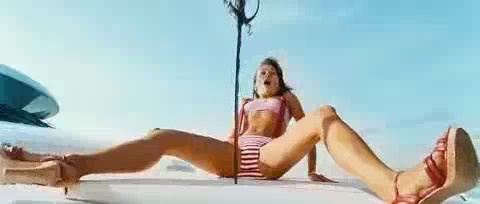

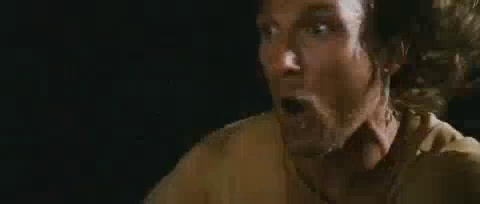

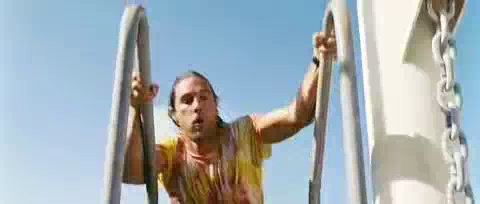

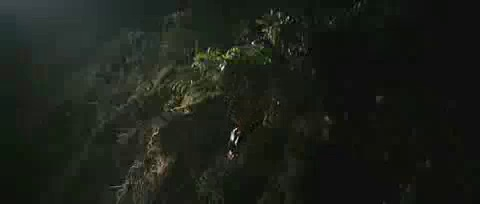

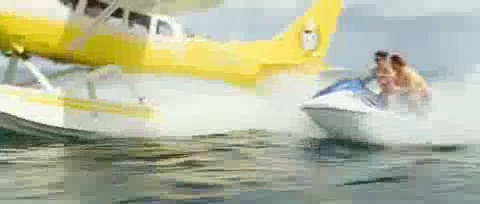

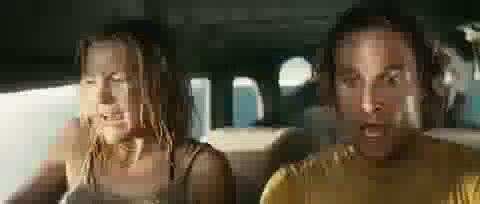

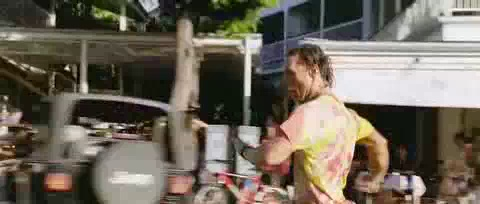

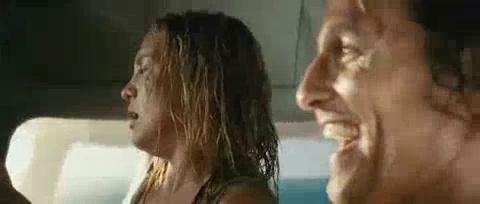

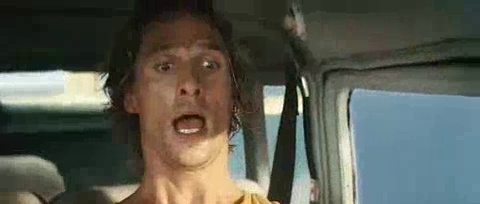

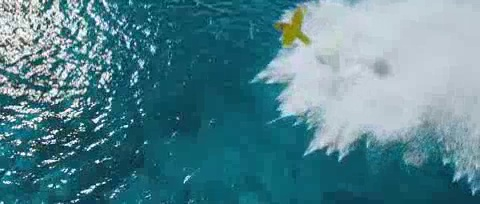

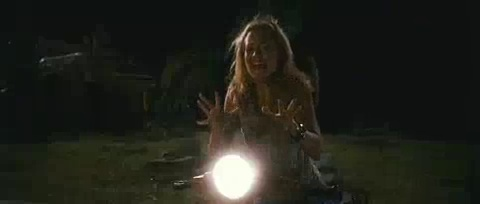

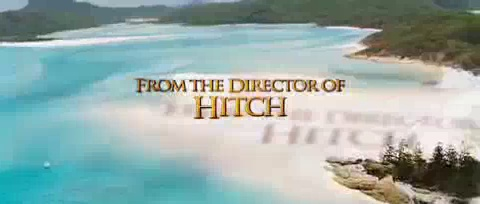

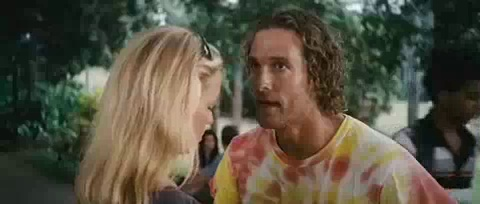

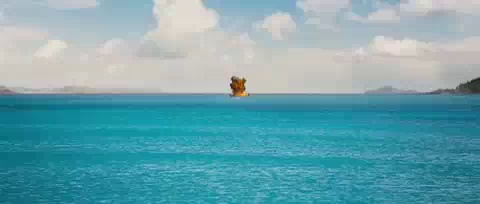

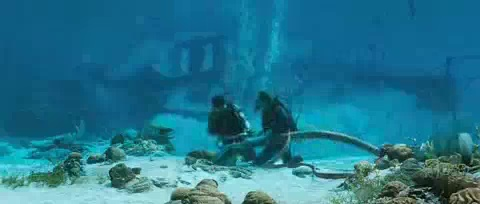

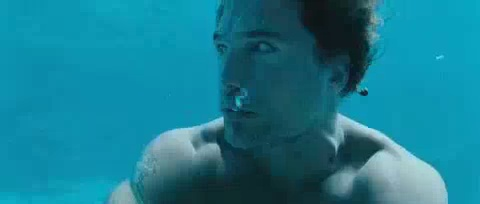

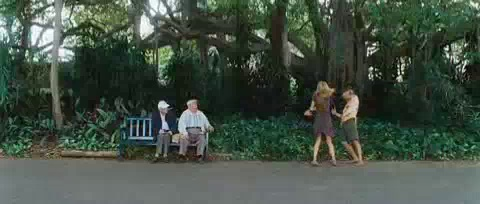

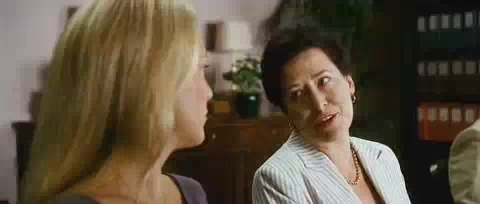

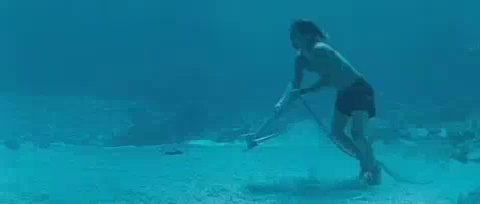

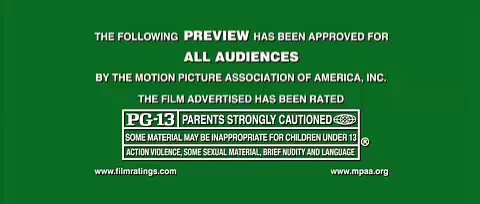

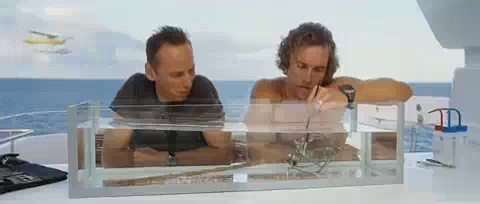

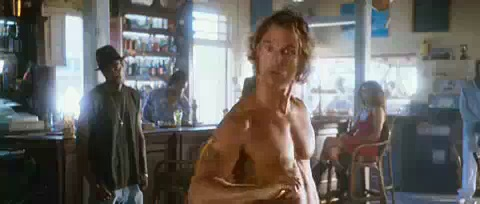

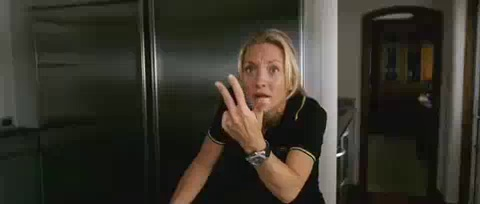

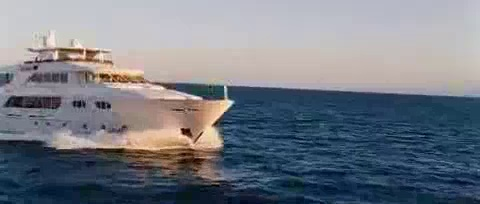

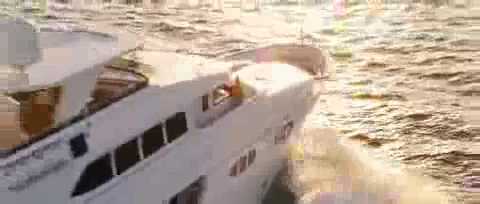

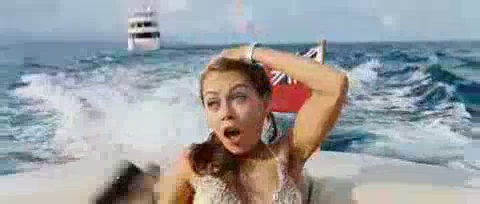

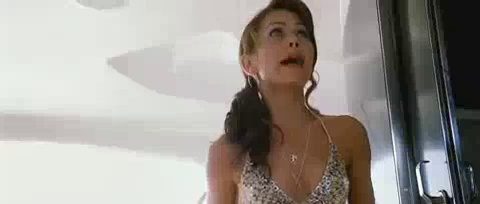

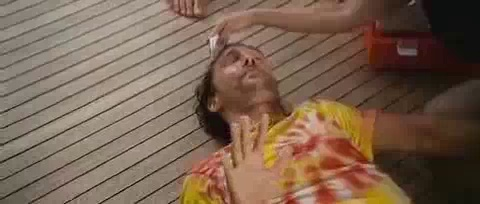

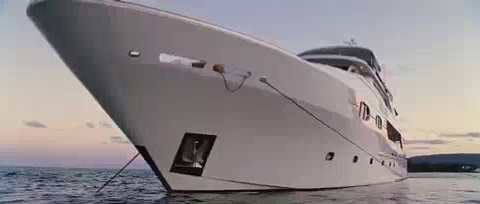

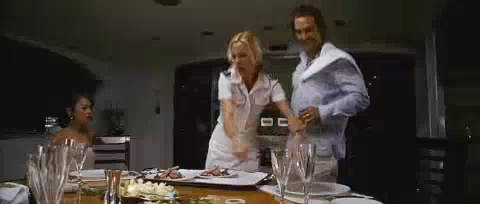

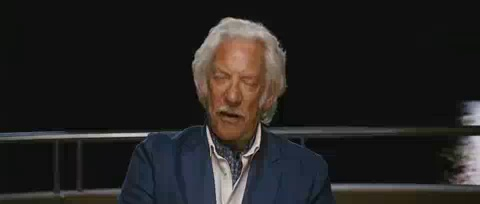

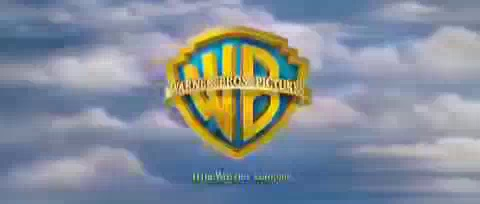

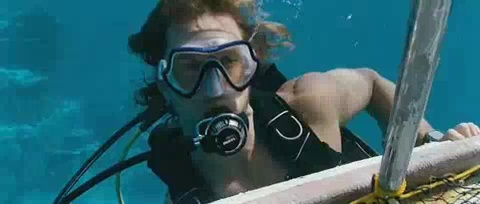

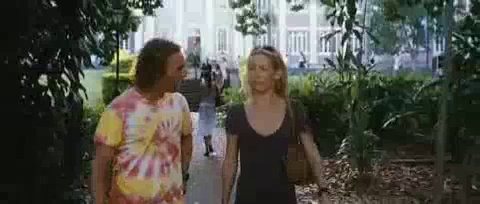

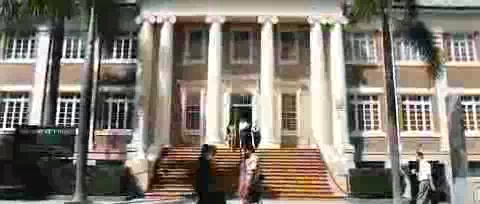

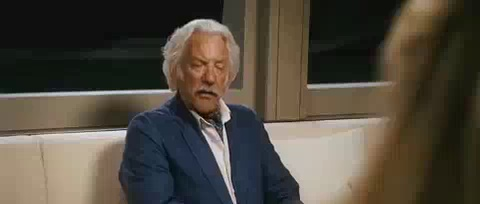

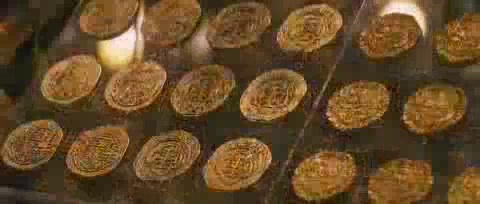

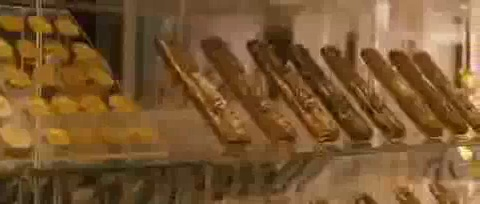

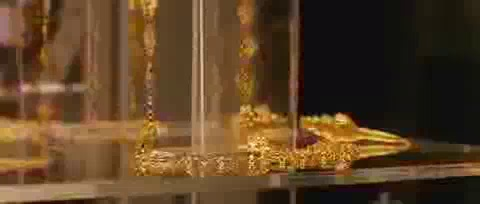

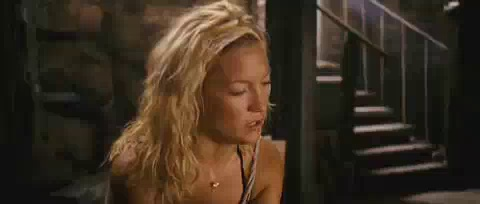

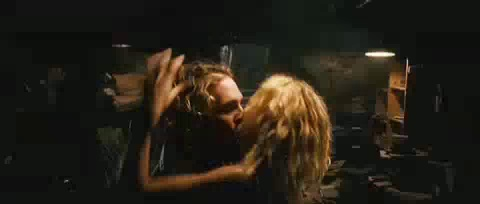

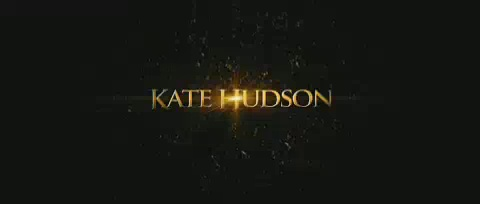

_____________________________________________________________________________________________________________
111772


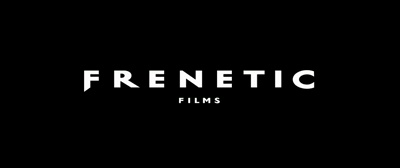

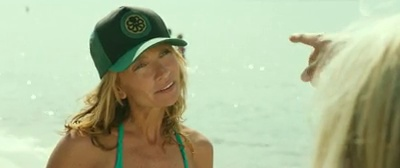

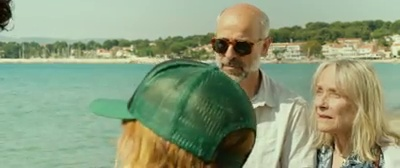

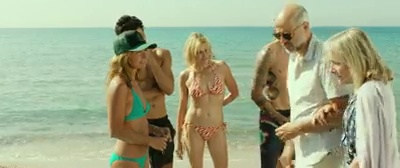

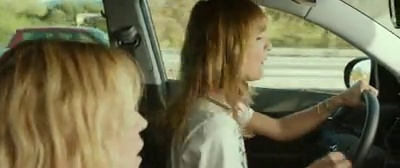

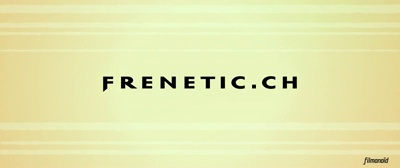

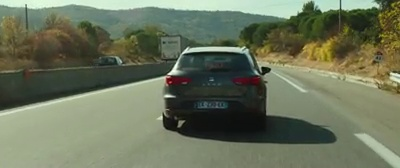

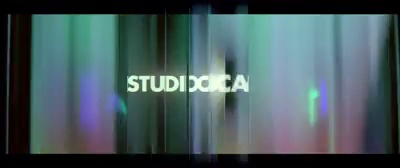

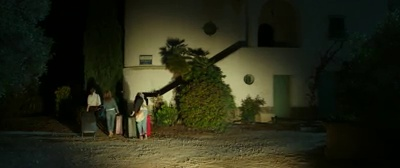

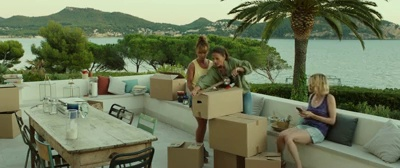

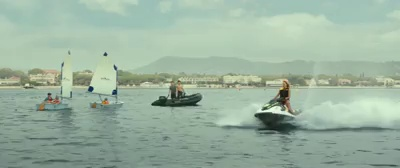

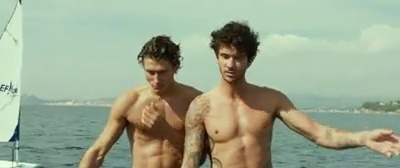

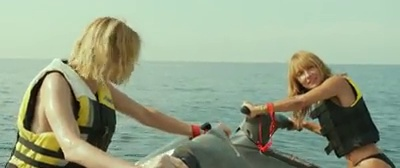

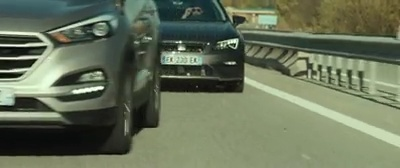

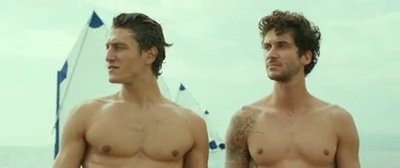

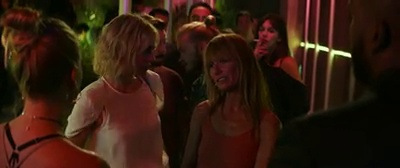

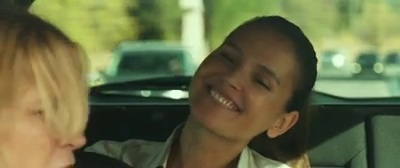

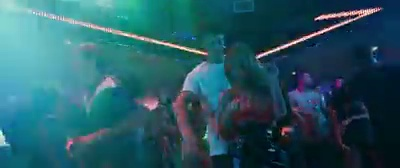

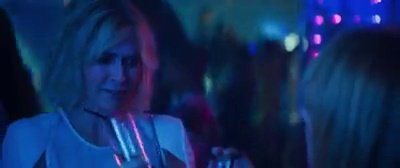

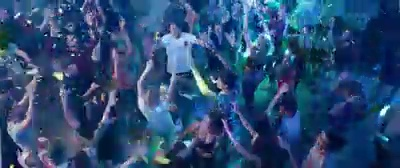

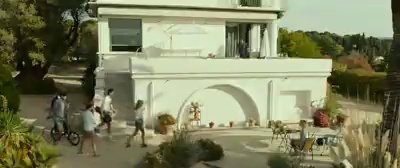

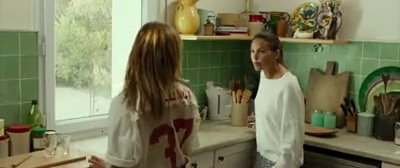

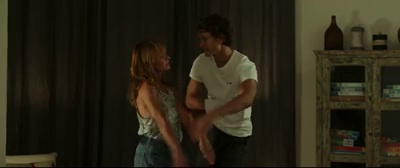

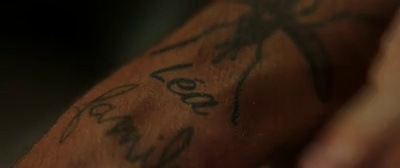

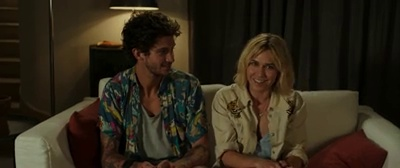

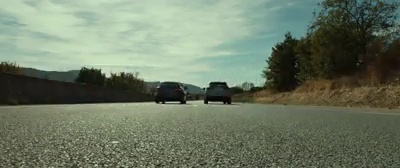

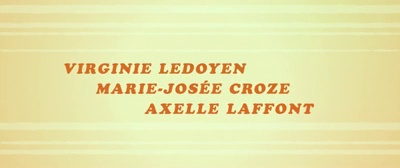

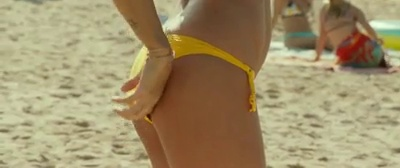

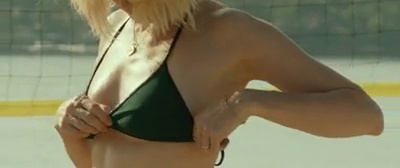

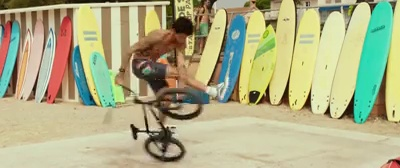

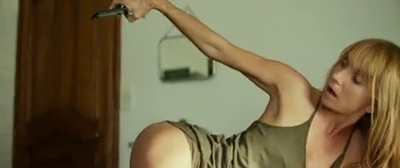

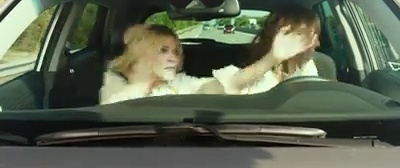

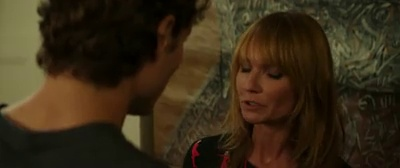

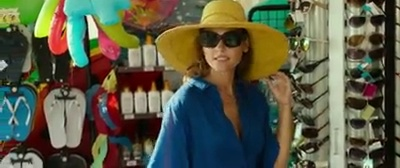

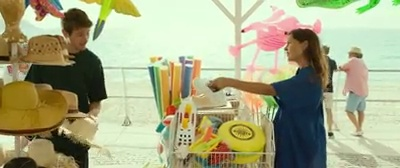

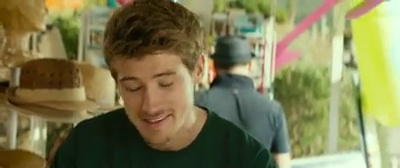

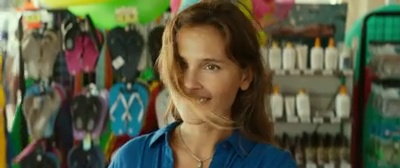

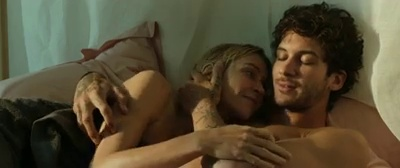

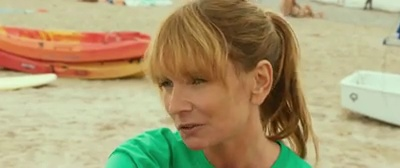

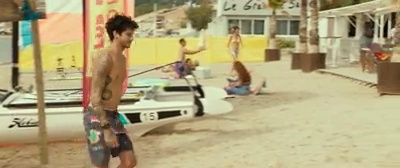

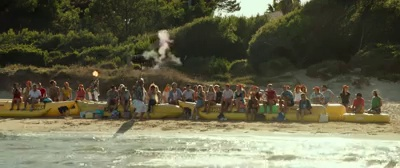

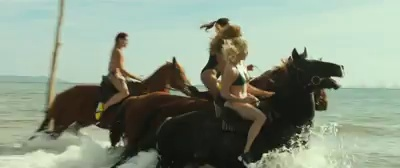

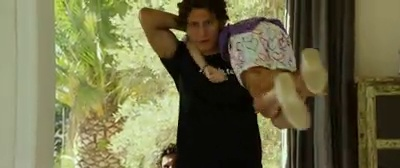

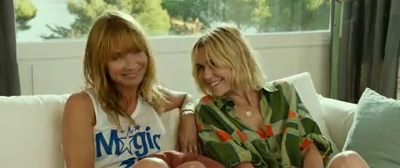

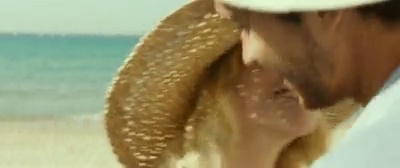

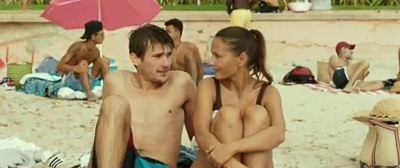

In [117]:
vidnum=105
show_keyframes_for_vid(videos[vidnum])
argmins = pairwise_distances_argmin_gpu(np.expand_dims(roberta_features[vidnum], axis=0), np.delete(roberta_features, vidnum, axis=0), bsz=1)
print('_____________________________________________________________________________________________________________')
print(int(argmins[0]))
show_keyframes_for_vid(videos[int(argmins[0])+1])

In [85]:
bof_features = [bag_of_frames(bpe_d) for bpe_d in bpe_data]

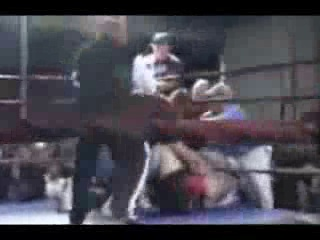

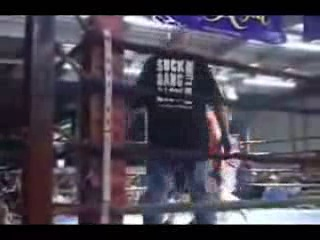

KeyboardInterrupt: 

In [114]:
vidnum=41
show_keyframes_for_vid(videos[vidnum])
argmins = pairwise_distances_argmin(np.expand_dims(bof_features[vidnum], axis=0), np.delete(bof_features, vidnum, axis=0))
print('____________________________________________________________________________________________________________')
print(int(argmins[0]+1))
show_keyframes_for_vid(videos[int(argmins[0])+1])

In [44]:
len(averaged_vid_features)

271899

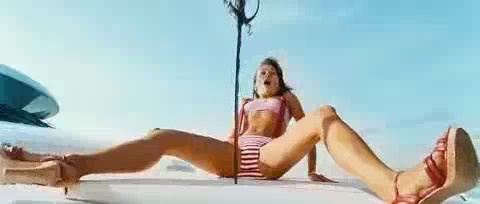

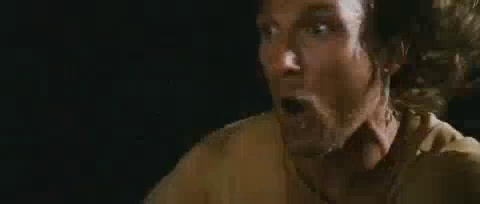

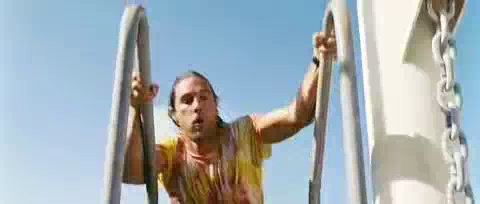

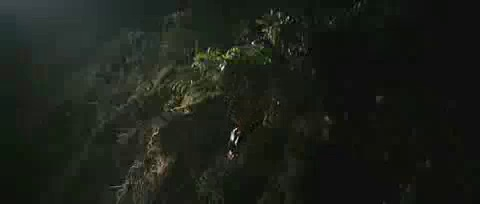

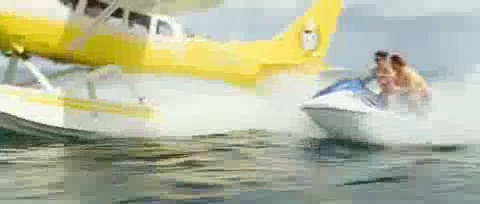

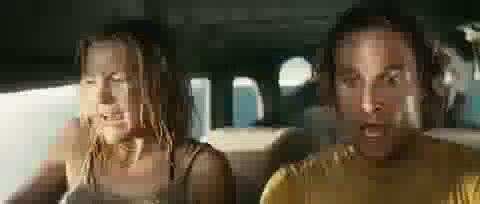

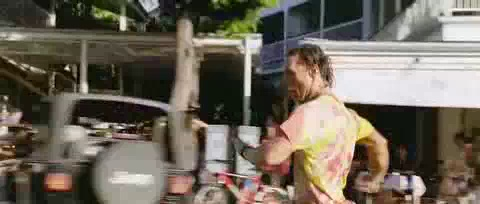

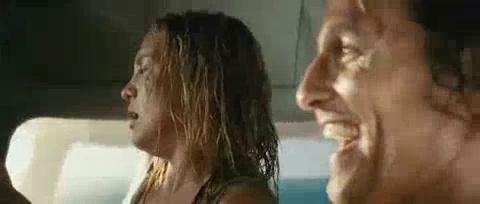

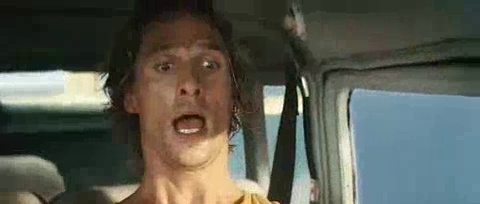

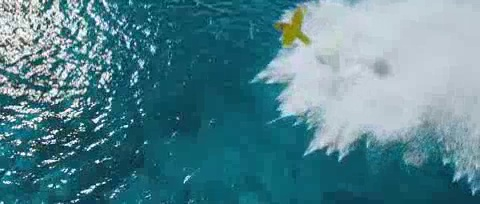

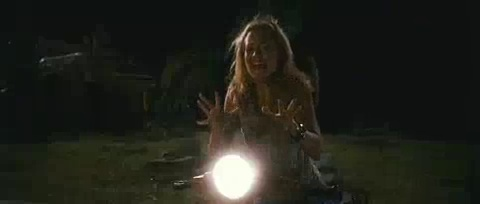

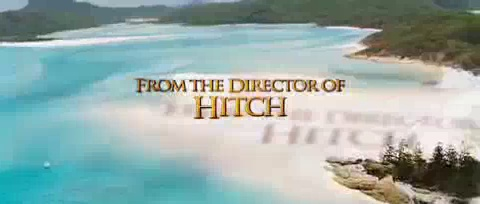

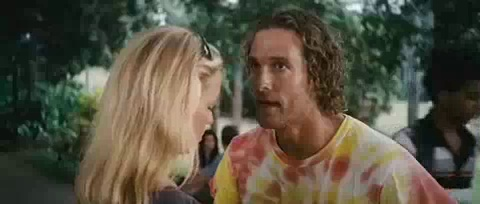

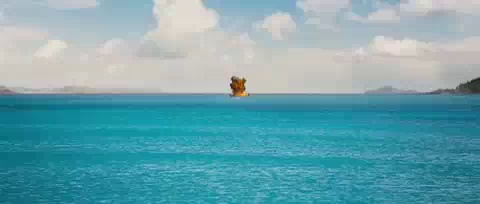

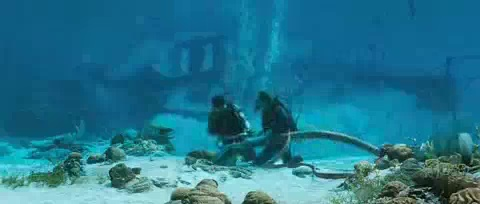

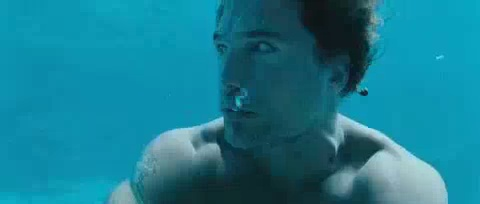

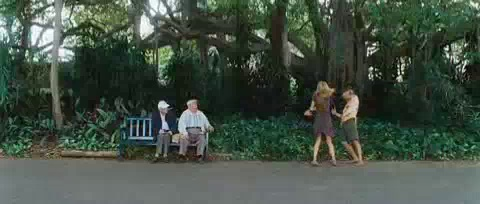

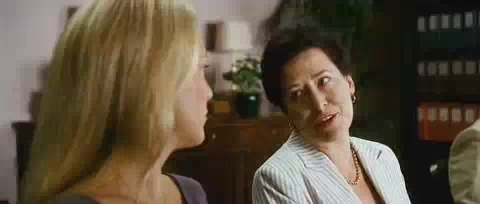

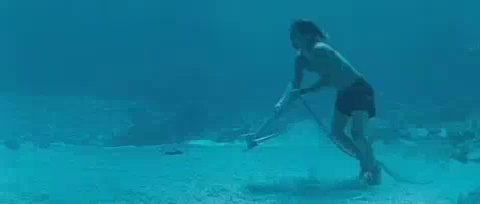

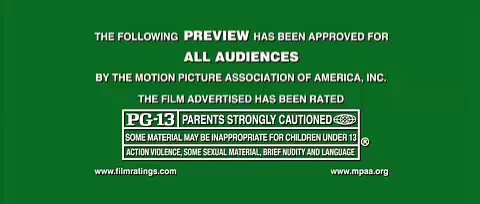

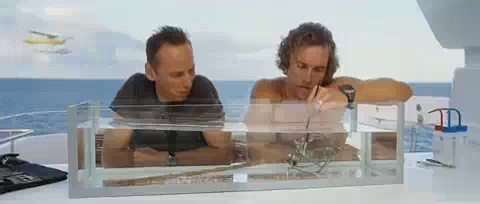

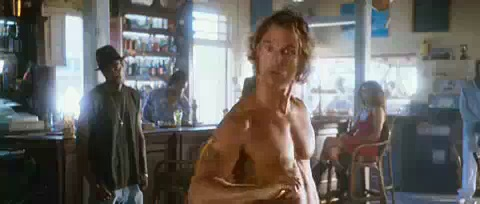

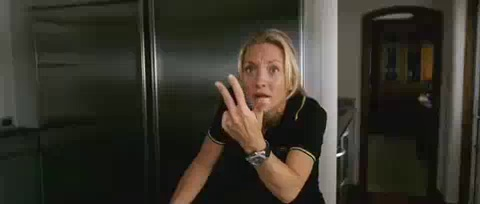

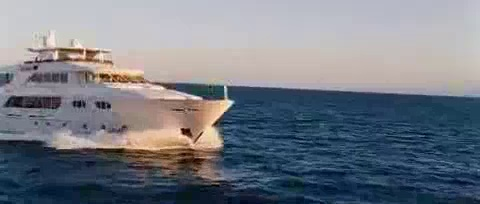

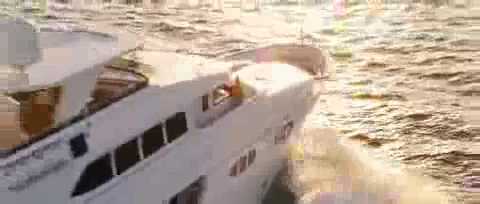

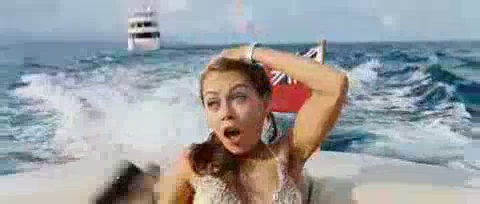

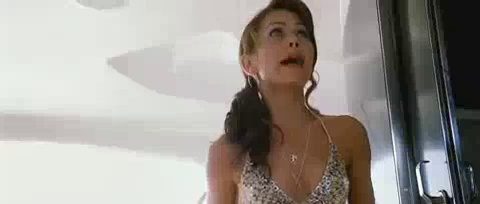

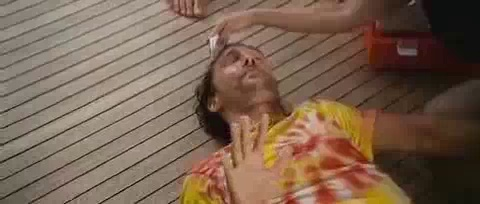

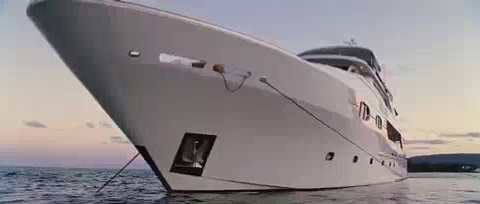

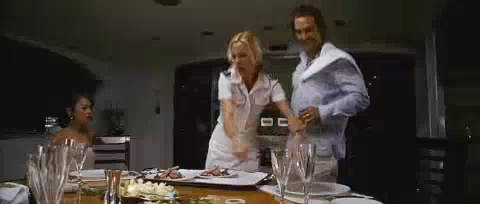

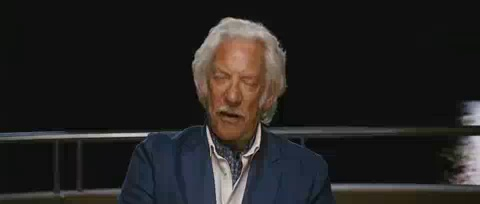

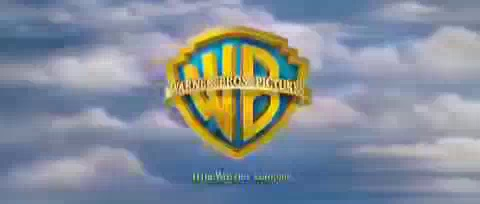

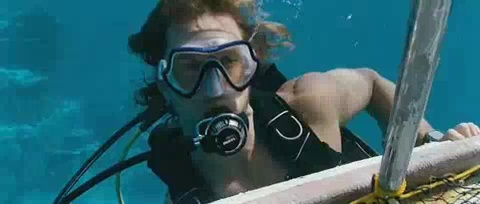

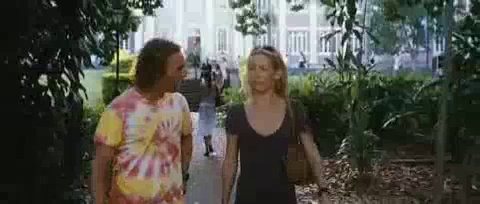

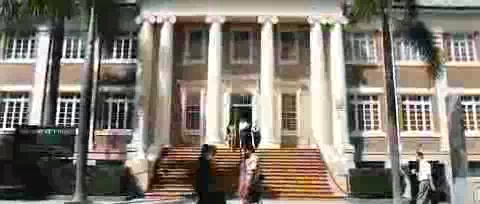

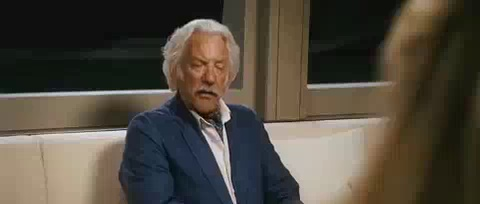

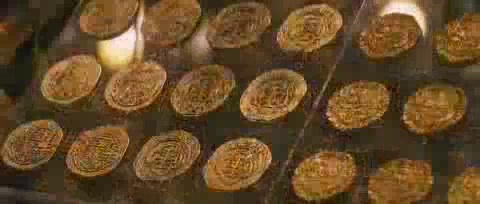

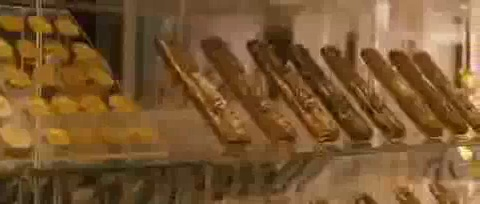

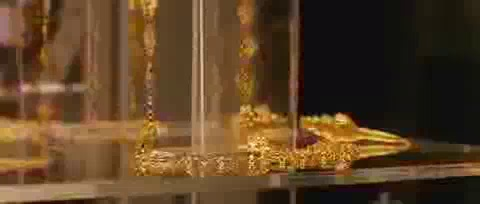

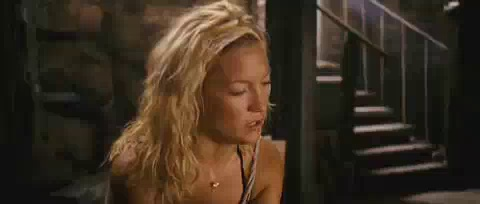

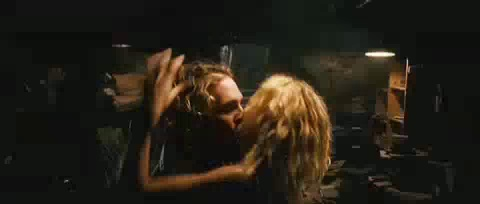

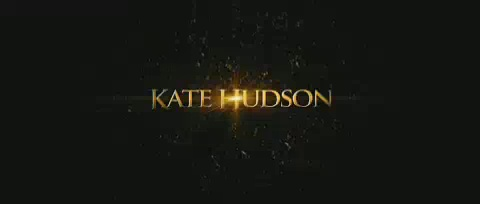

_____________________________________________________________________________________________________________
10019


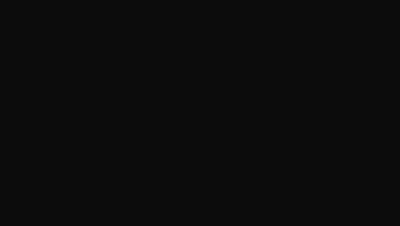

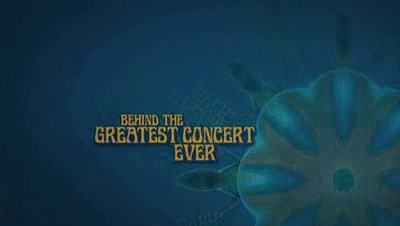

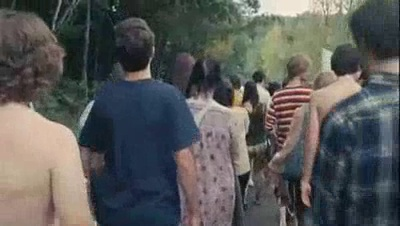

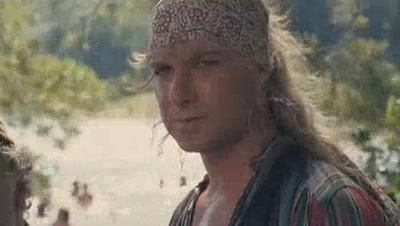

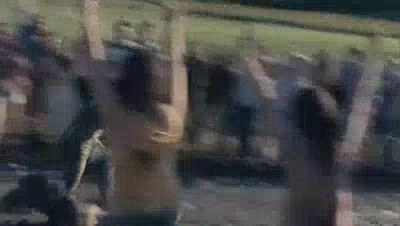

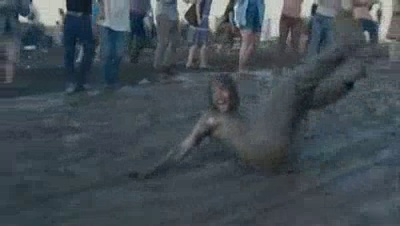

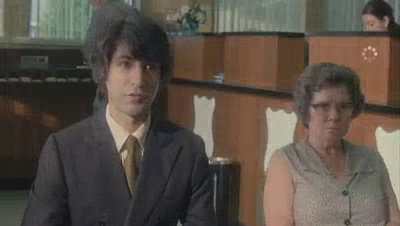

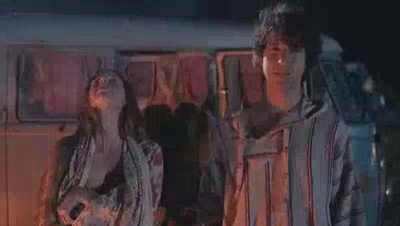

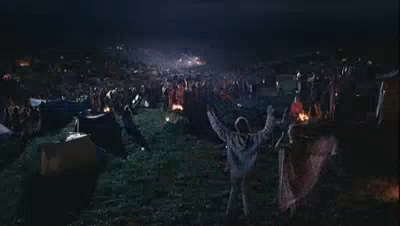

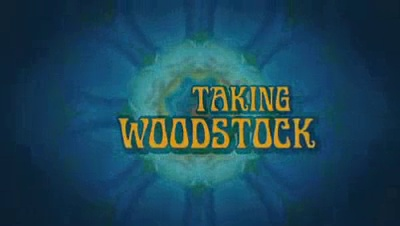

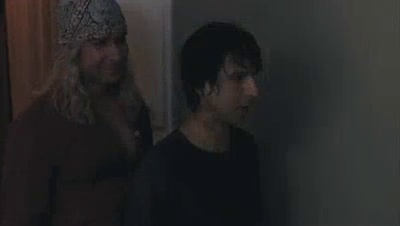

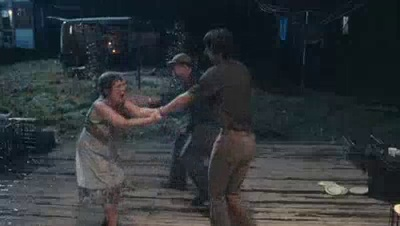

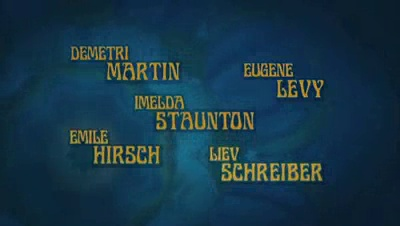

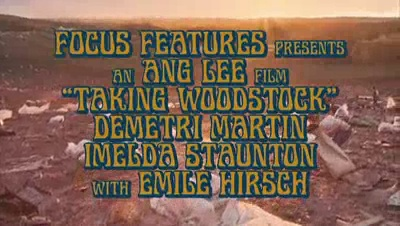

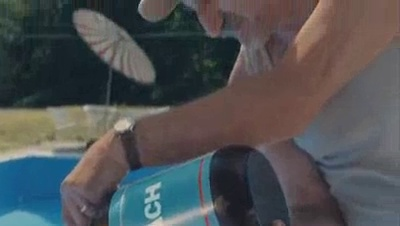

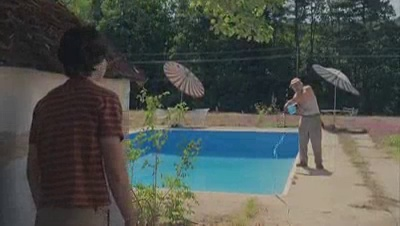

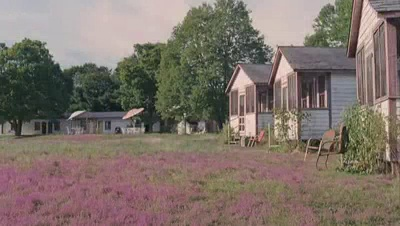

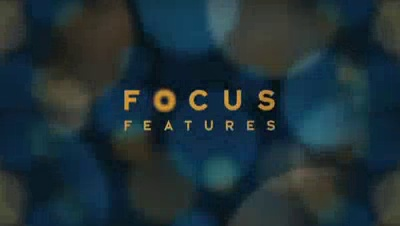

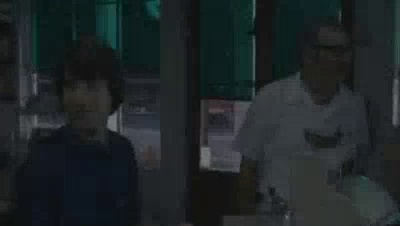

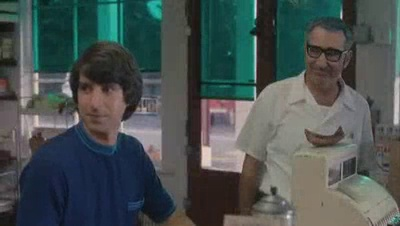

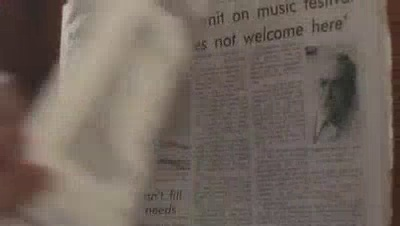

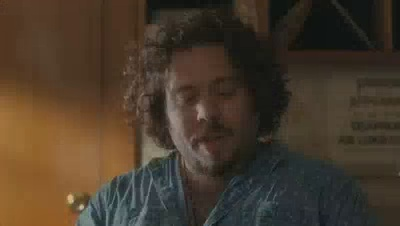

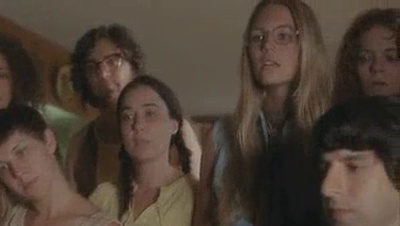

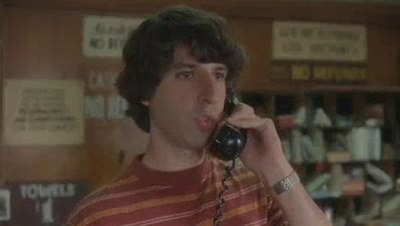

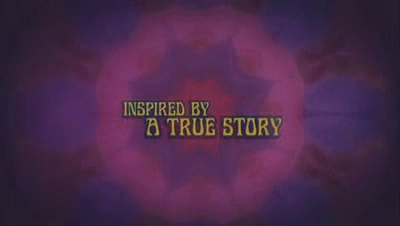

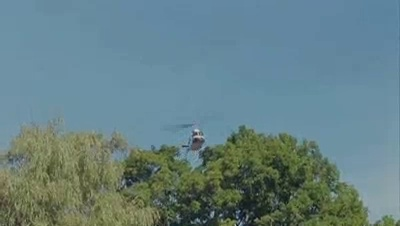

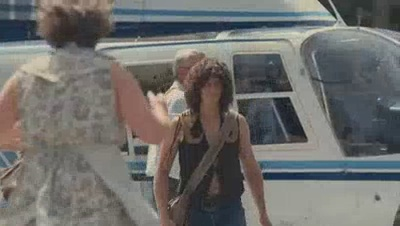

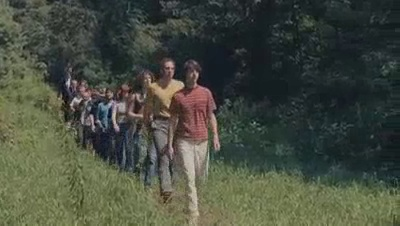

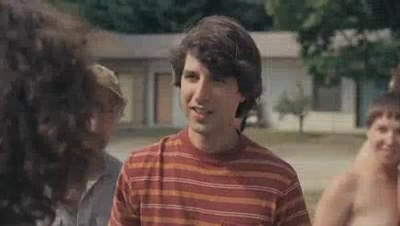

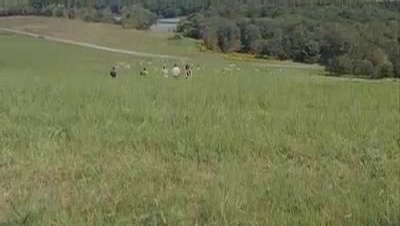

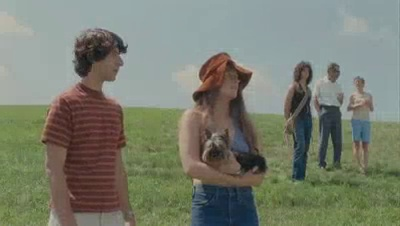

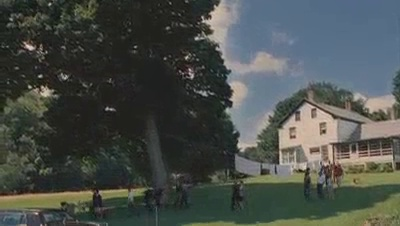

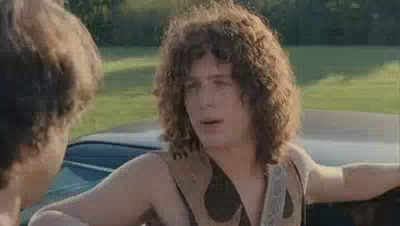

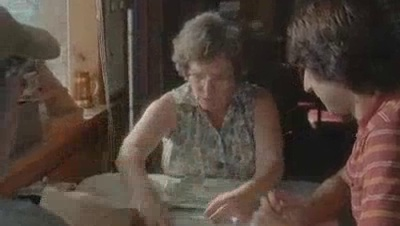

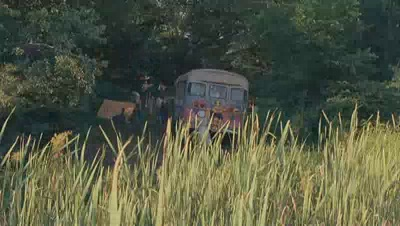

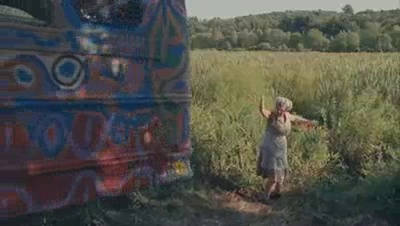

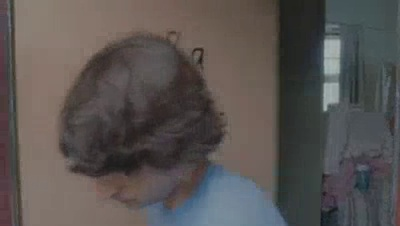

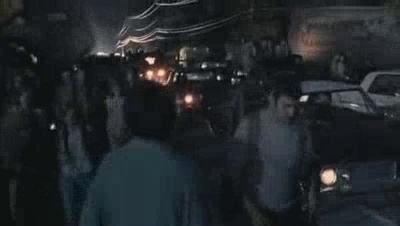

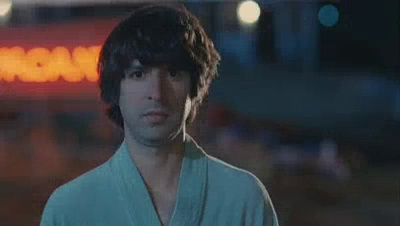

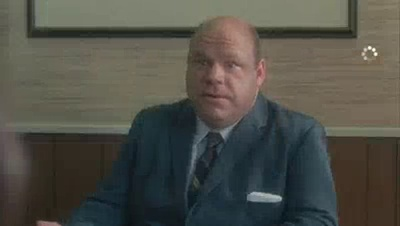

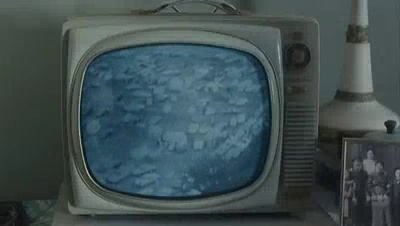

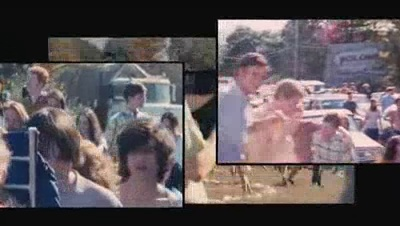

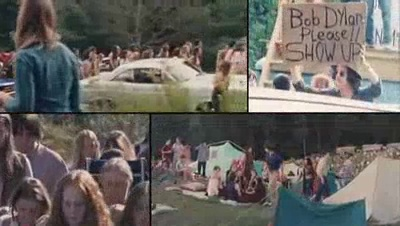

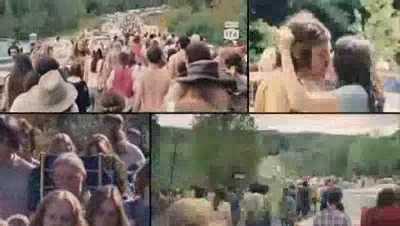

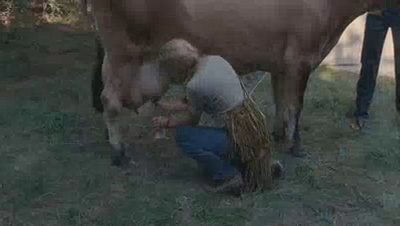

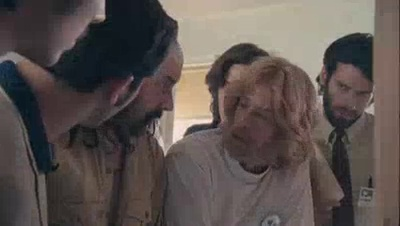

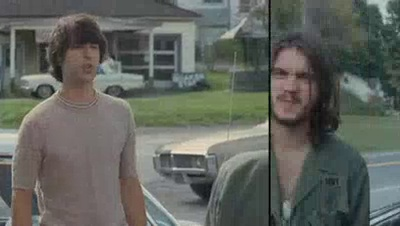

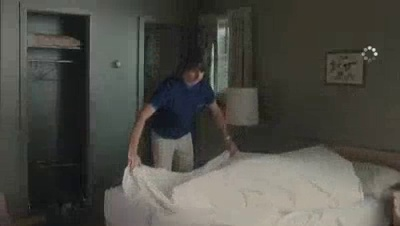

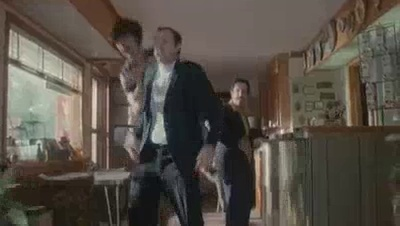

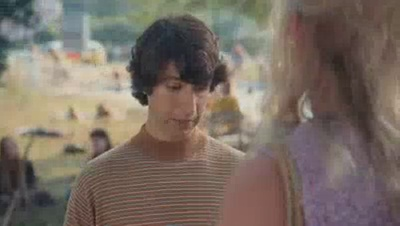

In [118]:
vidnum=105
show_keyframes_for_vid(videos[vidnum])
argmins = pairwise_distances_argmin(np.expand_dims(averaged_vid_features[vidnum], axis=0), np.delete(averaged_vid_features, vidnum, axis=0))
print('_____________________________________________________________________________________________________________')
print(int(argmins[0])+1)
show_keyframes_for_vid(videos[int(argmins[0])+1])

In [236]:
with open('/home/beckmann/imnet_10k/centroids_ordered.pkl', 'rb') as f:
    rawdata = f.read()
centroids_ordered = pickle.loads(rawdata)

In [178]:
def average_centroids(bpe_d, bpe_c, centroids):
    #for i in range(len(bpe_d)):
    #    bpe_d[i] = bpe_d[i] - 1
    if np.sum(bpe_c) > 0:
        return np.matmul(bpe_c, centroids[bpe_d]) / np.sum(bpe_c)
    else:
        return np.zeros(512)

In [179]:
average_centroids_representations = [average_centroids(bpe_d, bpe_c, centroids_ordered) for bpe_d, bpe_c in zip(bpe_data, bpe_counts)]

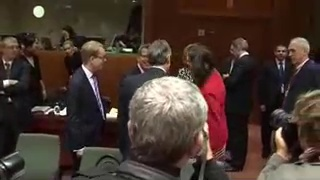

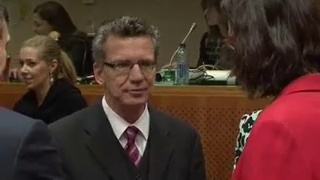

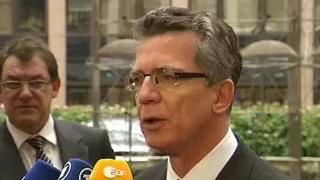

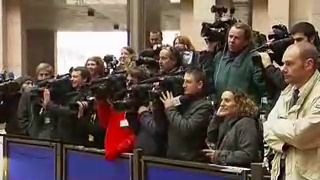

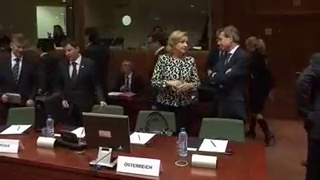

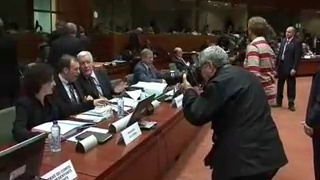

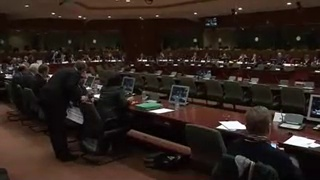

_____________________________________________________________________________________________________________
16372


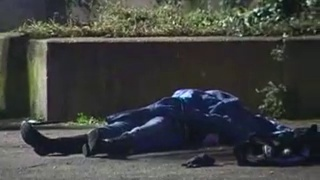

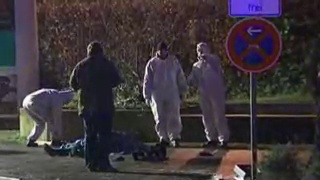

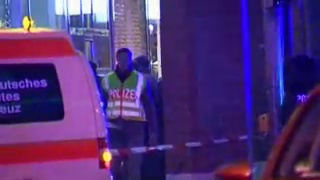

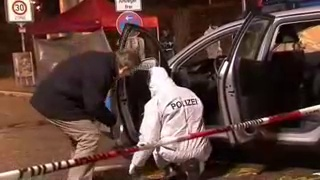

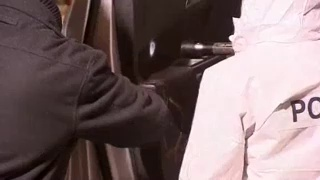

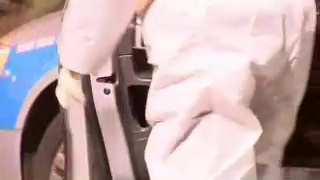

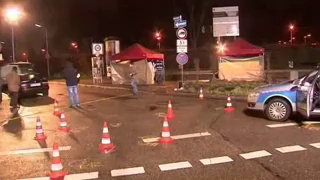

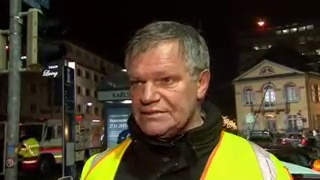

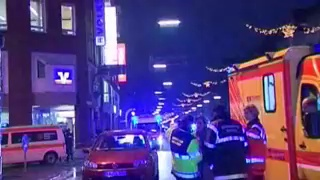

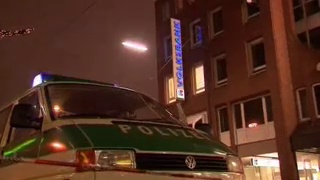

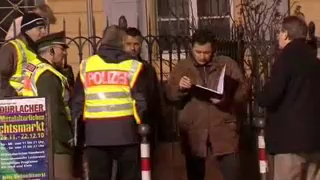

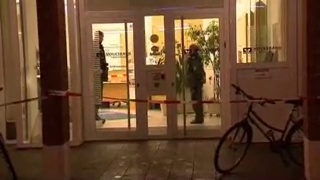

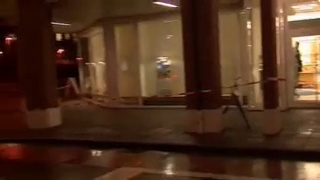

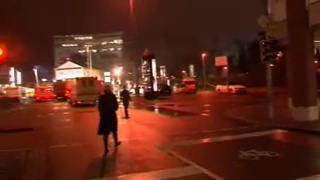

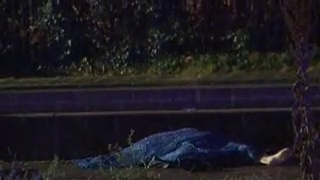

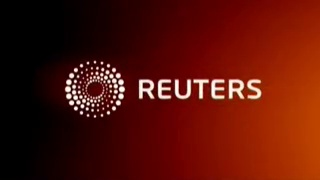

In [224]:
vidnum=0
show_keyframes_for_vid(videos[vidnum])
argmins = pairwise_distances_argmin(np.expand_dims(average_centroids_representations[vidnum], axis=0), np.delete(average_centroids_representations, vidnum, axis=0))
print('_____________________________________________________________________________________________________________')
print(int(argmins[0]+1))
show_keyframes_for_vid(videos[int(argmins[0])+1])